### Entangling gate on two coupled qubits

#### Imports

In [1]:
!pip install -q -U pip
!pip install -q matplotlib

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.


In [10]:
import sys
sys.path.append('/home/llguo/PycharmProjects/c3/')

In [11]:
import c3
c3

<module 'c3' from '/home/llguo/PycharmProjects/c3/c3/__init__.py'>

In [9]:
# System imports
import copy
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from typing import List
from pprint import pprint

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils

# Qiskit related modules
from c3.qiskit import C3Provider
from c3.qiskit.c3_gates import RX90pGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram

#### Model components
The model consists of two qubits with 3 levels each and slightly different parameters:

In [4]:
qubit_lvls = 3
freq_q1 = 5e9
anhar_q1 = -210e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(value=freq_q1, min_val=4.995e9, max_val=5.005e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q1, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q1, min_val=1e-6, max_val=90e-6, unit='s'),
    t2star=Qty(value=t2star_q1, min_val=10e-6, max_val=90e-3, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

freq_q2 = 5.6e9
anhar_q2 = -240e6
t1_q2 = 23e-6
t2star_q2 = 31e-6
q2 = chip.Qubit(
    name="Q2",
    desc="Qubit 2",
    freq=Qty(value=freq_q2, min_val=5.595e9, max_val=5.605e9, unit='Hz 2pi'),
    anhar=Qty(value=anhar_q2, min_val=-380e6, max_val=-120e6, unit='Hz 2pi'),
    hilbert_dim=qubit_lvls,
    t1=Qty(value=t1_q2, min_val=1e-6, max_val=90e-6,unit='s'),
    t2star=Qty(value=t2star_q2, min_val=10e-6, max_val=90e-6, unit='s'),
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit='K')
)

2022-05-17 15:48:24.480281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 15:48:24.480972: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 15:48:24.481076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-17 15:48:24.481158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-17 15:48:24.481242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

There is a static coupling in x-direction between them: $(b_1+b_1^\dagger)(b_2+b_2^\dagger)$

In [5]:
coupling_strength = 50e6
q1q2 = chip.Coupling(
    name="Q1-Q2",
    desc="coupling",
    comment="Coupling qubit 1 to qubit 2",
    connected=["Q1", "Q2"],
    strength=Qty(
        value=coupling_strength,
        min_val=-1 * 1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

and each qubit has a drive line

In [6]:
drive1 = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)
drive2 = chip.Drive(
    name="d2",
    desc="Drive 2",
    comment="Drive line 2 on qubit 2",
    connected=["Q2"],
    hamiltonian_func=hamiltonians.x_drive
)

All parts are collected in the model.

In [7]:
model = Mdl(
    [q1, q2], # Individual, self-contained components
    [drive1, drive2, q1q2],  # Interactions between components
)
model.set_lindbladian(False)
model.set_dressed(True)

#### Control signals
The devices for the control line are set up

In [8]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG
v2hz = 1e9

lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')
dig_to_an = devices.DigitalToAnalog(name="dac", resolution=sim_res)
v_to_hz = devices.VoltsToHertz(
    name='v_to_hz',
    V_to_Hz=Qty(value=v2hz, min_val=0.9e9, max_val=1.1e9, unit='Hz/V')
)

The generator combines the parts of the signal generation and assignes a signal chain to each control line.

In [9]:
generator = Gnr(
        devices={
            "LO": lo,
            "AWG": awg,
            "DigitalToAnalog": dig_to_an,
            "Mixer": mixer,
            "VoltsToHertz": v_to_hz
        },
        chains={
            "d1": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"],
            },
            "d2": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"],
            }
        }
    )

#### Gates-set and Parameter map
Following a general cross resonance scheme, both qubits will be resonantly driven at the frequency of qubit 2 with a Gaussian envelope. We drive qubit 1 (the control) at the frequency of qubit 2 (the target) with a higher amplitude to compensate for the reduced Rabi frequency.

In [10]:
t_final_2Q = 45e-9
sideband = 50e6
gauss_params_2Q_1 = {
    'amp': Qty(value=0.8, min_val=0.2, max_val=3, unit="V"),
    't_final': Qty(value=t_final_2Q, min_val=0.5 * t_final_2Q, max_val=1.5 * t_final_2Q, unit="s"),
    'sigma': Qty(value=t_final_2Q / 4, min_val=t_final_2Q / 8, max_val=t_final_2Q / 2, unit="s"),
    'xy_angle': Qty(value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit='rad'),
    'freq_offset': Qty(value=-sideband - 3e6, min_val=-56 * 1e6, max_val=-52 * 1e6, unit='Hz 2pi'),
    'delta': Qty(value=-1, min_val=-5, max_val=3, unit="")
}

gauss_params_2Q_2 = {
    'amp': Qty(value=0.03, min_val=0.02, max_val=0.6, unit="V"),
    't_final': Qty(value=t_final_2Q, min_val=0.5 * t_final_2Q, max_val=1.5 * t_final_2Q, unit="s"),
    'sigma': Qty(value=t_final_2Q / 4, min_val=t_final_2Q / 8, max_val=t_final_2Q / 2, unit="s"),
    'xy_angle': Qty(value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit='rad'),
    'freq_offset': Qty(value=-sideband - 3e6, min_val=-56 * 1e6, max_val=-52 * 1e6, unit='Hz 2pi'),
    'delta': Qty(value=-1, min_val=-5, max_val=3, unit="")
}

gauss_env_2Q_1 = pulse.Envelope(
    name="gauss1",
    desc="Gaussian envelope on drive 1",
    params=gauss_params_2Q_1,
    shape=envelopes.gaussian_nonorm
)
gauss_env_2Q_2 = pulse.Envelope(
    name="gauss2",
    desc="Gaussian envelope on drive 2",
    params=gauss_params_2Q_2,
    shape=envelopes.gaussian_nonorm
)

We choose a single qubit gate time of 7ns and a gaussian envelope shape with a list of parameters.

In [11]:
t_final_1Q = 7e-9   # Time for single qubit gates
sideband = 50e6 
gauss_params_single = {
    'amp': Qty(
        value=0.5,
        min_val=0.2,
        max_val=0.6,
        unit="V"
    ),
    't_final': Qty(
        value=t_final_1Q,
        min_val=0.5 * t_final_1Q,
        max_val=1.5 * t_final_1Q,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final_1Q / 4,
        min_val=t_final_1Q / 8,
        max_val=t_final_1Q / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}

In [12]:
gauss_env_1Q = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm
)

We also define a gate that represents no driving (used for the single qubit gates).

In [13]:
nodrive_env = pulse.Envelope(
    name="no_drive",
    params={
        't_final': Qty(
            value=t_final_1Q,
            min_val=0.5 * t_final_1Q,
            max_val=1.5 * t_final_1Q,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)

The carrier signal of each drive for the 2 Qubit gates is set to the resonance frequency of the target qubit.

In [14]:
lo_freq_q1 = freq_q1 + sideband
lo_freq_q2 = freq_q2 + sideband

carr_2Q_1 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 1",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

carr_2Q_2 = pulse.Carrier(
    name="carrier",
    desc="Carrier on drive 2",
    params={
        'freq': Qty(value=lo_freq_q2, min_val=0.9 * lo_freq_q2, max_val=1.1 * lo_freq_q2, unit='Hz 2pi'),
        'framechange': Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit='rad')
    }
)

We specify the drive tones for the 1Q gates with an offset from the qubit frequencies. As is done in experiment, we will later adjust the resonance by modulating the envelope function.

In [15]:
carr_1Q_1 = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params={
    'freq': Qty(
        value=lo_freq_q1,
        min_val=0.9 * lo_freq_q1 ,
        max_val=1.1 * lo_freq_q1 ,
        unit='Hz 2pi'
    ),
    'framechange': Qty(
        value=0.0,
        min_val= -np.pi,
        max_val= 3 * np.pi,
        unit='rad'
    )
}
)

carr_1Q_2 = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params={
    'freq': Qty(
        value=lo_freq_q2,
        min_val=0.9 * lo_freq_q2 ,
        max_val=1.1 * lo_freq_q2 ,
        unit='Hz 2pi'
    ),
    'framechange': Qty(
        value=0.0,
        min_val= -np.pi,
        max_val= 3 * np.pi,
        unit='rad'
    )
}
)

#### Instructions
The instruction to be optimised is a CNOT gates controlled by qubit 1.

In [16]:
# CNOT comtrolled by qubit 1
cnot12 = gates.Instruction(
    name="cx", targets=[0, 1], t_start=0.0, t_end=t_final_2Q, channels=["d1", "d2"],
    ideal=np.array([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,0,1],
        [0,0,1,0]
    ])
)
cnot12.add_component(gauss_env_2Q_1, "d1")
cnot12.add_component(carr_2Q_1, "d1")
cnot12.add_component(gauss_env_2Q_2, "d2")
cnot12.add_component(carr_2Q_2, "d2")
cnot12.comps["d1"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final_2Q) * 2 * np.pi % (2 * np.pi)
)

We also add some typical single qubit gates to the instruction set.

In [17]:
rx90p_q1 = gates.Instruction(
    name="rx90p", targets=[0], t_start=0.0, t_end=t_final_1Q, channels=["d1", "d2"]
)
rx90p_q2 = gates.Instruction(
    name="rx90p", targets=[1], t_start=0.0, t_end=t_final_1Q, channels=["d1", "d2"]
)

rx90p_q1.add_component(gauss_env_1Q, "d1")
rx90p_q1.add_component(carr_1Q_1, "d1")


rx90p_q2.add_component(gauss_env_1Q, "d2")
rx90p_q2.add_component(carr_1Q_2, "d2")

When later compiling gates into sequences, we have to take care of the relative rotating frames of the qubits and local oscillators. We do this by adding a phase after each gate that realigns the frames.

In [18]:
rx90p_q1.add_component(nodrive_env, "d2")
rx90p_q1.add_component(copy.deepcopy(carr_1Q_2), "d2")
rx90p_q1.comps["d2"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final_1Q) * 2 * np.pi % (2 * np.pi)
)

rx90p_q2.add_component(nodrive_env, "d1")
rx90p_q2.add_component(copy.deepcopy(carr_1Q_1), "d1")
rx90p_q2.comps["d1"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final_1Q) * 2 * np.pi % (2 * np.pi)
)

#### The experiment
All components are collected in the parameter map and the experiment is set up.

In [19]:
parameter_map = PMap(instructions=[cnot12, rx90p_q1, rx90p_q2], model=model, generator=generator)
exp = Exp(pmap=parameter_map)

#### Dynamics

The system is initialised in the state $|0,1\rangle$ so that a transition to $|1,1\rangle$ should be visible.

In [20]:
psi_init = [[0] * 9]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
print(init_state)

tf.Tensor(
[[1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]], shape=(9, 1), dtype=complex128)


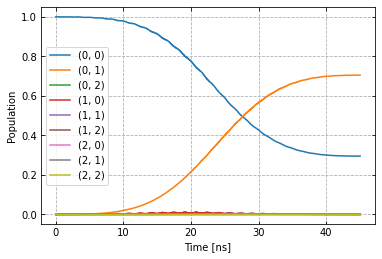

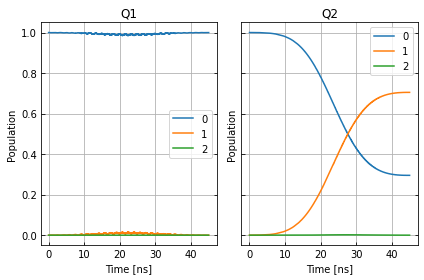

In [21]:
def plot_dynamics(exp, psi_init, seq):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        """
        model = exp.pmap.model
        exp.compute_propagators()
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

def getQubitsPopulation(population: np.array, dims: List[int]) -> np.array:
    """
    Splits the population of all levels of a system into the populations of levels per subsystem.
    Parameters
    ----------
    population: np.array
        The time dependent population of each energy level. First dimension: level index, second dimension: time.
    dims: List[int]
        The number of levels for each subsystem.
    Returns
    -------
    np.array
        The time-dependent population of energy levels for each subsystem. First dimension: subsystem index, second
        dimension: level index, third dimension: time.
    """
    numQubits = len(dims)

    # create a list of all levels
    qubit_levels = []
    for dim in dims:
        qubit_levels.append(list(range(dim)))
    combined_levels = list(itertools.product(*qubit_levels))

    # calculate populations
    qubitsPopulations = np.zeros((numQubits, dims[0], population.shape[1]))
    for idx, levels in enumerate(combined_levels):
        for i in range(numQubits):
            qubitsPopulations[i, levels[i]] += population[idx]
    return qubitsPopulations

def plotSplittedPopulation(
    exp: Exp,
    psi_init: tf.Tensor,
    sequence: List[str]
) -> None:
    """
    Plots time dependent populations for multiple qubits in separate plots.
    Parameters
    ----------
    exp: Experiment
        The experiment containing the model and propagators
    psi_init: np.array
        Initial state vector
    sequence: List[str]
        List of gate names that will be applied to the state
    -------
    """
    # calculate the time dependent level population
    model = exp.pmap.model
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in sequence:
        for du in dUs[gate]:
            psi_t = np.matmul(du, psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)
    dims = [s.hilbert_dim for s in model.subsystems.values()]
    splitted = getQubitsPopulation(pop_t, dims)

    # timestamps
    dt = exp.ts[1] - exp.ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])

    # create both subplots
    titles = list(exp.pmap.model.subsystems.keys())
    fig, axs = plt.subplots(1, len(splitted), sharey="all")
    for idx, ax in enumerate(axs):
        ax.plot(ts / 1e-9, splitted[idx].T)
        ax.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Population")
        ax.set_title(titles[idx])
        ax.legend([str(x) for x in np.arange(dims[idx])])
        ax.grid()

    plt.tight_layout()
    plt.show()

sequence = [cnot12.get_key()]
plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

#### Visualisation with qiskit circuit

In [23]:
qc = QuantumCircuit(2)
qc.append(RX90pGate(), [0])
qc.cx(0, 1)
qc.draw()

┌────────────┐     
q_0: ┤ Rx90p(π/2) ├──■──
     └────────────┘┌─┴─┐
q_1: ──────────────┤ X ├
                   └───┘

In [24]:
c3_provider = C3Provider()
c3_backend = c3_provider.get_backend("c3_qasm_physics_simulator")
c3_backend.set_c3_experiment(exp)

In [25]:
c3_job_unopt = c3_backend.run(qc)
result_unopt = c3_job_unopt.result()
res_pops_unopt = result_unopt.data()["state_pops"]
print("Result from unoptimized gates:")
pprint(res_pops_unopt)

Result from unoptimized gates:
{'(0, 0)': 0.0822617168009913,
 '(0, 1)': 0.18909133977645926,
 '(0, 2)': 1.4241544525424904e-05,
 '(1, 0)': 0.3609924318656775,
 '(1, 1)': 0.3555090482678217,
 '(1, 2)': 4.815852947619383e-06,
 '(2, 0)': 0.0081360697678527,
 '(2, 1)': 0.003990097959792842,
 '(2, 2)': 2.3816370114966761e-07}


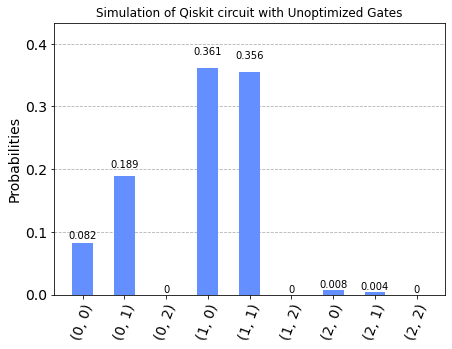

In [26]:
plot_histogram(res_pops_unopt, title='Simulation of Qiskit circuit with Unoptimized Gates')

#### Open-loop optimal control

Now, open-loop optimisation with DRAG enabled is set up.

In [27]:
generator.devices['AWG'].enable_drag_2()

opt_gates = [cnot12.get_key()]
exp.set_opt_gates(opt_gates)

gateset_opt_map=[
    [(cnot12.get_key(), "d1", "gauss1", "amp")],
    [(cnot12.get_key(), "d1", "gauss1", "freq_offset")],
    [(cnot12.get_key(), "d1", "gauss1", "xy_angle")],
    [(cnot12.get_key(), "d1", "gauss1", "delta")],
    [(cnot12.get_key(), "d1", "carrier", "framechange")],
    [(cnot12.get_key(), "d2", "gauss2", "amp")],
    [(cnot12.get_key(), "d2", "gauss2", "freq_offset")],
    [(cnot12.get_key(), "d2", "gauss2", "xy_angle")],
    [(cnot12.get_key(), "d2", "gauss2", "delta")],
    [(cnot12.get_key(), "d2", "carrier", "framechange")],
]
parameter_map.set_opt_map(gateset_opt_map)

parameter_map.print_parameters()

cx[0, 1]-d1-gauss1-amp                : 800.000 mV 
cx[0, 1]-d1-gauss1-freq_offset        : -53.000 MHz 2pi 
cx[0, 1]-d1-gauss1-xy_angle           : -444.089 arad 
cx[0, 1]-d1-gauss1-delta              : -1.000  
cx[0, 1]-d1-carrier-framechange       : 4.712 rad 
cx[0, 1]-d2-gauss2-amp                : 30.000 mV 
cx[0, 1]-d2-gauss2-freq_offset        : -53.000 MHz 2pi 
cx[0, 1]-d2-gauss2-xy_angle           : -444.089 arad 
cx[0, 1]-d2-gauss2-delta              : -1.000  
cx[0, 1]-d2-carrier-framechange       : 0.000 rad 



As a fidelity function we choose unitary fidelity as well as LBFG-S (a wrapper of the scipy implementation) from our library.

In [28]:
import os
import tempfile
from c3.optimizers.optimalcontrol import OptimalControl

log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")
opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=["Q1", "Q2"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={
        "maxfun": 25
    },
    run_name="cnot12"
)

Start the optimisation

In [29]:
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)
opt.optimize_controls()

C3:STATUS:Saving as: /tmp/tmp_vgmvcyj/c3logs/cnot12/2022_05_17_T_15_50_24/open_loop.c3log


The final parameters and the fidelity are

In [30]:
parameter_map.print_parameters()
print(opt.current_best_goal)

cx[0, 1]-d1-gauss1-amp                : 199.980 mV 
cx[0, 1]-d1-gauss1-freq_offset        : -52.980 MHz 2pi 
cx[0, 1]-d1-gauss1-xy_angle           : 215.299 mrad 
cx[0, 1]-d1-gauss1-delta              : -946.133 m 
cx[0, 1]-d1-carrier-framechange       : 5.899 rad 
cx[0, 1]-d2-gauss2-amp                : 20.056 mV 
cx[0, 1]-d2-gauss2-freq_offset        : -53.006 MHz 2pi 
cx[0, 1]-d2-gauss2-xy_angle           : -96.721 mrad 
cx[0, 1]-d2-gauss2-delta              : -973.779 m 
cx[0, 1]-d2-carrier-framechange       : 187.279 mrad 

0.7890683395758453


#### Results of the optimisation
Plotting the dynamics with the same initial state:

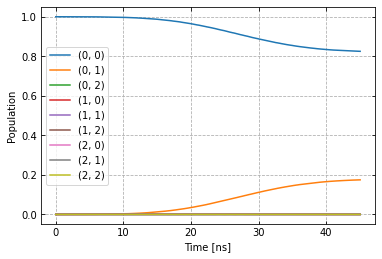

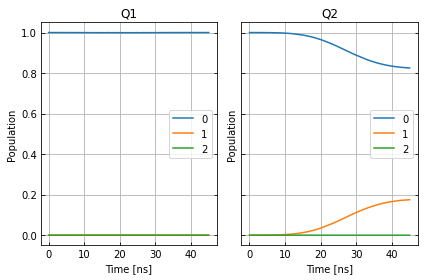

In [31]:
plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

Now we plot the dynamics for the control in the excited state.

tf.Tensor(
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]], shape=(9, 1), dtype=complex128)


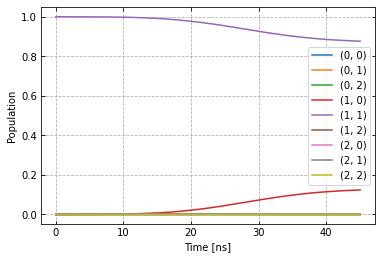

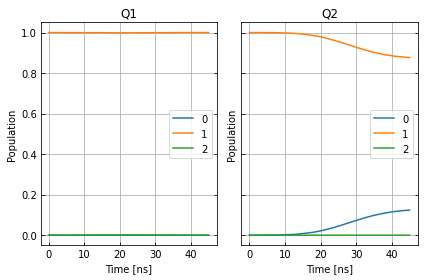

In [32]:
psi_init = [[0] * 9]
psi_init[0][4] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
print(init_state)

plot_dynamics(exp, init_state, sequence)
plotSplittedPopulation(exp, init_state, sequence)

As intended, the dynamics of the target is dependent on the control qubit performing a flip if the control is excited and an identity otherwise.

#### Optimizing the single qubit gate on Qubit 1

In [33]:
opt_gates = [rx90p_q1.get_key()]
gateset_opt_map=[
    [
      (rx90p_q1.get_key(), "d1", "gauss", "amp"),
    ],
    [
      (rx90p_q1.get_key(), "d1", "gauss", "freq_offset"),
    ],
    [
      (rx90p_q1.get_key(), "d1", "gauss", "xy_angle"),
    ],
    [
      (rx90p_q1.get_key(), "d1", "gauss", "delta"),
    ],   
    [
      (rx90p_q1.get_key(), "d1", "carrier", "framechange"),
    ]
]
parameter_map.set_opt_map(gateset_opt_map)
parameter_map.print_parameters()

rx90p[0]-d1-gauss-amp                 : 500.000 mV 
rx90p[0]-d1-gauss-freq_offset         : -53.000 MHz 2pi 
rx90p[0]-d1-gauss-xy_angle            : -444.089 arad 
rx90p[0]-d1-gauss-delta               : -1.000  
rx90p[0]-d1-carrier-framechange       : 0.000 rad 



In [34]:
opt_1Q = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=["Q1", "Q2"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={
        "maxfun": 25
    },
    run_name="rx90p_q1"
)

In [35]:
exp.set_opt_gates(opt_gates)
opt_1Q.set_exp(exp)
opt_1Q.optimize_controls()

C3:STATUS:Saving as: /tmp/tmp_vgmvcyj/c3logs/rx90p_q1/2022_05_17_T_15_51_37/open_loop.c3log


In [36]:
parameter_map.print_parameters()
print(opt_1Q.current_best_goal)

rx90p[0]-d1-gauss-amp                 : 386.167 mV 
rx90p[0]-d1-gauss-freq_offset         : -52.985 MHz 2pi 
rx90p[0]-d1-gauss-xy_angle            : -148.032 mrad 
rx90p[0]-d1-gauss-delta               : -960.910 m 
rx90p[0]-d1-carrier-framechange       : -293.001 mrad 

0.005569018116723501


Before running the qiskit simulation, we must call `set_opt_gates()` to ensure propagators are calculated for all the required gates

In [37]:
exp.set_opt_gates([rx90p_q1.get_key(), cnot12.get_key()])

In [38]:
c3_job_opt = c3_backend.run(qc)
result_opt = c3_job_opt.result()
res_pops_opt = result_opt.data()["state_pops"]
print("Result from gates:") 
pprint(res_pops_opt)

Result from gates:
{'(0, 0)': 0.40143100577627705,
 '(0, 1)': 0.08496310269936586,
 '(0, 2)': 7.788657470650952e-07,
 '(1, 0)': 0.44925769339946137,
 '(1, 1)': 0.0635824598194806,
 '(1, 2)': 1.974760165424923e-07,
 '(2, 0)': 0.0007543938737482897,
 '(2, 1)': 1.03680813877436e-05,
 '(2, 2)': 8.207707536198608e-12}


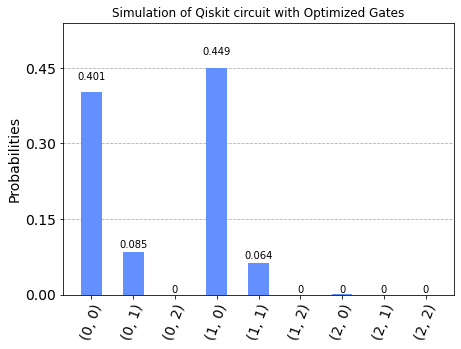

In [39]:
plot_histogram(res_pops_opt, title='Simulation of Qiskit circuit with Optimized Gates')